In [398]:
from tkinter import *

In [399]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt       # matplotlib.pyplot plots data
%matplotlib inline 
import seaborn as sns
import random
import string

In [400]:
import mysql.connector

cnx = mysql.connector.connect(user='root', password='asdqwe123',
                              host='localhost',
                              database='Telecome')
cursor = cnx.cursor()

cursor.execute('select * from telecome_churn')
table_rows = cursor.fetchall()

df = pd.DataFrame(table_rows)


In [401]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,30,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,57,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,54,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,71,151.65,Yes


In [402]:
df.columns = ['customerID','gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','Churn']

In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [404]:
df.shape

(7043, 21)

#### To replace missing/null value which only exists in "TotalCharges", we need see the distribution of "TotalCharges" to decide we discard those values as zero or median

In [405]:
df.describe(include='all').transpose

<bound method DataFrame.transpose of         customerID gender  SeniorCitizen Partner Dependents       tenure  \
count         7043   7043    7043.000000    7043       7043  7043.000000   
unique        7043      2            NaN       2          2          NaN   
top     8902-ZEOVF   Male            NaN      No         No          NaN   
freq             1   3555            NaN    3641       4933          NaN   
mean           NaN    NaN       0.162147     NaN        NaN    32.371149   
std            NaN    NaN       0.368612     NaN        NaN    24.559481   
min            NaN    NaN       0.000000     NaN        NaN     0.000000   
25%            NaN    NaN       0.000000     NaN        NaN     9.000000   
50%            NaN    NaN       0.000000     NaN        NaN    29.000000   
75%            NaN    NaN       0.000000     NaN        NaN    55.000000   
max            NaN    NaN       1.000000     NaN        NaN    72.000000   

       PhoneService MultipleLines InternetService 

#### max value for "TotalCharges" suggest there will be outliers

c:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


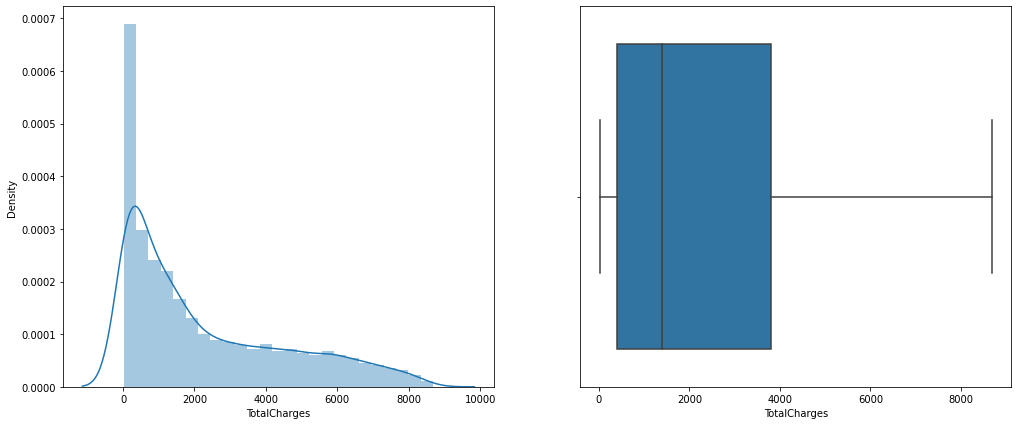

In [406]:
f, axes = plt.subplots(1, 2, figsize=(17,7))
sns.boxplot(x = 'TotalCharges', data=df , ax=axes[1])
sns.distplot(df['TotalCharges'],  ax=axes[0])
plt.show()

#### The "TotalCharges" is right sckewed. But as there are no outliers, we can replace null/missing values with median 

In [407]:
from sklearn.impute import SimpleImputer
dfnew = df['TotalCharges'].to_frame()
rep_0 = SimpleImputer(missing_values=np.nan, strategy="median")
cols=dfnew.columns
dfnew = pd.DataFrame(rep_0.fit_transform(dfnew))

In [408]:
df['TotalCharges'] = dfnew

In [409]:
df.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

#### We need to look at the value of all attributes contributing in building the model. CustomerID seems unique and brings no value to this

In [410]:
dfnew =  df.drop('customerID',axis=1)

In [411]:
print("Gender:"+dfnew['gender'].unique())
print("Partner:"+dfnew['Partner'].unique())
print("Dependents:"+dfnew['Dependents'].unique())
print("PhoneService:"+dfnew['PhoneService'].unique())
print("MultipleLines:"+dfnew['MultipleLines'].unique())
print("InternetService:"+dfnew['InternetService'].unique())
print("OnlineSecurity:"+dfnew['OnlineSecurity'].unique())
print("OnlineBackup:"+dfnew['OnlineBackup'].unique())
print("DeviceProtection:"+dfnew['DeviceProtection'].unique())
print("TechSupport:"+dfnew['TechSupport'].unique())
print("StreamingTV:"+dfnew['StreamingTV'].unique())
print("StreamingMovies:"+dfnew['StreamingMovies'].unique())
print("Contract:"+dfnew['Contract'].unique())
print("PaperlessBilling:"+dfnew['PaperlessBilling'].unique())
print("PaymentMethod:"+dfnew['PaymentMethod'].unique())

['Gender:Female' 'Gender:Male']
['Partner:Yes' 'Partner:No']
['Dependents:No' 'Dependents:Yes']
['PhoneService:No' 'PhoneService:Yes']
['MultipleLines:No phone service' 'MultipleLines:No' 'MultipleLines:Yes']
['InternetService:DSL' 'InternetService:Fiber optic' 'InternetService:No']
['OnlineSecurity:No' 'OnlineSecurity:Yes'
 'OnlineSecurity:No internet service']
['OnlineBackup:Yes' 'OnlineBackup:No' 'OnlineBackup:No internet service']
['DeviceProtection:No' 'DeviceProtection:Yes'
 'DeviceProtection:No internet service']
['TechSupport:No' 'TechSupport:Yes' 'TechSupport:No internet service']
['StreamingTV:No' 'StreamingTV:Yes' 'StreamingTV:No internet service']
['StreamingMovies:No' 'StreamingMovies:Yes'
 'StreamingMovies:No internet service']
['Contract:Month-to-month' 'Contract:One year' 'Contract:Two year']
['PaperlessBilling:Yes' 'PaperlessBilling:No']
['PaymentMethod:Electronic check' 'PaymentMethod:Mailed check'
 'PaymentMethod:Bank transfer (automatic)'
 'PaymentMethod:Credit card

In [412]:
dfnew.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,30,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,57,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,54,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,71,151.65,Yes


In [413]:
dfnew['Churn'].replace(to_replace='Yes', value=1, inplace=True)
dfnew['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [414]:
dfnew['MonthlyCharges'] = dfnew['MonthlyCharges'].astype('float32')

In [415]:
df_dummies = pd.get_dummies(dfnew)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,30.0,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,57.0,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,54.0,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.0,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,71.0,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


df_dummies.info()

In [416]:
#Remove redundant data
#dfnew =  df.drop(['gender_Male','Partner_No','Dependents_No','PhoneService_No','MultipleLines_No','InternetService_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No','Contract_Month-to-month','PaperlessBilling_No','PaymentMethod_Mailed check'],axis=1)

# Data Analysis & Visulaization

In [417]:
dfnew.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043,NaN,NaN,NaN,0.162147,0.368612,0,0,0,0,1
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043,NaN,NaN,NaN,32.3711,24.5595,0,9,29,55,72
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,7043,3,No,3088,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Tenure, MonthlyCharges and TotalCharges are continuous variables. Above data shows that MonthlyCharges are slightly right sckewed with few outliers. Tenure seems to be normally distributed. TotalCharges are seems to left sckewed. Lets find more with visuals.

# Univariant analysis

c:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


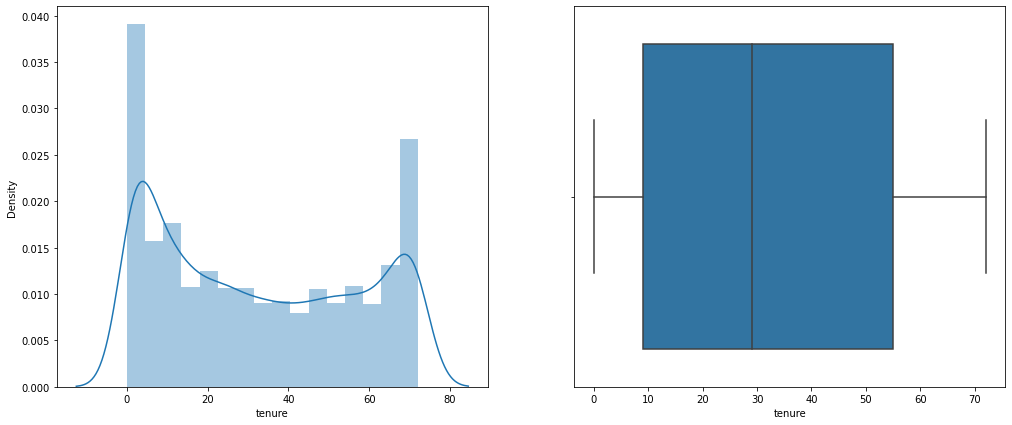

In [144]:
f, axes = plt.subplots(1, 2, figsize=(17,7))
sns.boxplot(x = 'tenure', data=dfnew , ax=axes[1])
sns.distplot(dfnew['tenure'],  ax=axes[0])
plt.show()

#### Tenure is fairly normally distributed without outliers. 

c:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


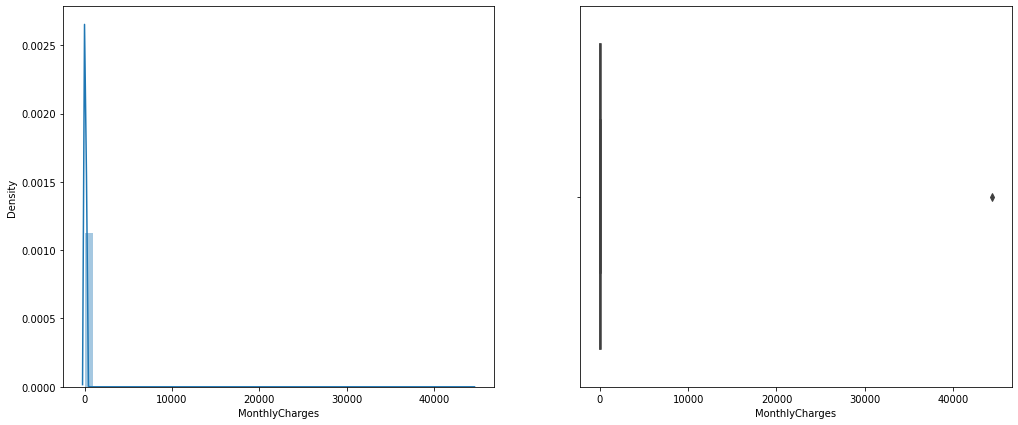

In [134]:
f, axes = plt.subplots(1, 2, figsize=(17,7))
sns.boxplot(x = 'MonthlyCharges', data=dfnew , ax=axes[1])
sns.distplot(dfnew['MonthlyCharges'],  ax=axes[0])
plt.show()

#### It seems that there is one outlier affecting the projection of MonthlyCharges.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


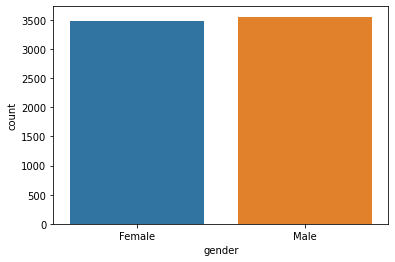

In [136]:
sns.countplot('gender',data=dfnew)
plt.show()

#### Gender seems to be equally distributed. Survey data contains approximately equal number of males and females.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


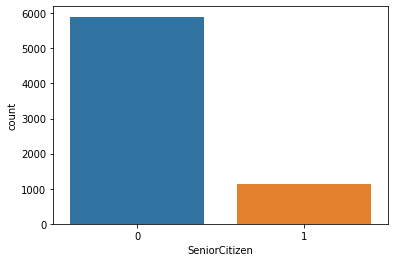

In [137]:
sns.countplot('SeniorCitizen',data=dfnew)
plt.show()

#### Number of Senior citizens are less in the original data.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


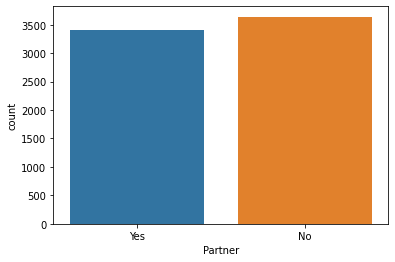

In [138]:
sns.countplot('Partner',data=dfnew)
plt.show()

#### Data involves almost equal % of people who are partner and who are not.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


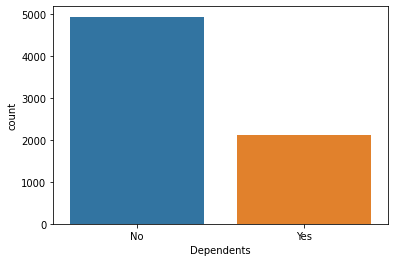

In [140]:
sns.countplot('Dependents',data=dfnew)
plt.show()

#### Count of Dependents is lesser(almost half) than Non-Dependents.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


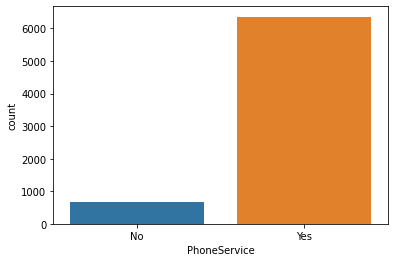

In [141]:
sns.countplot('PhoneService',data=dfnew)
plt.show()

#### Most of the Customers involved in this data have PhoneService.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


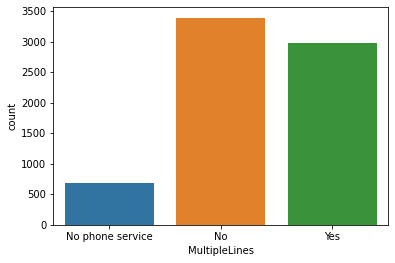

In [142]:
sns.countplot('MultipleLines',data=dfnew)
plt.show()

#### As we saw, there are few Customers with No Phone service. But who has service involves more customers one Line than customers with Multiple Lines.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


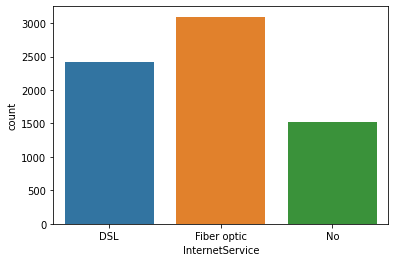

In [143]:
sns.countplot('InternetService',data=dfnew)
plt.show()

#### More customers have InternetService with Fiber optic(approx. 3100), less with DSL(approx. 2400) and lesser without InternerService(approx. 1500).

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


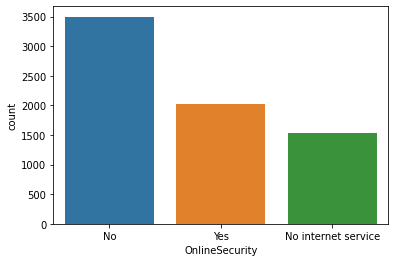

In [145]:
sns.countplot('OnlineSecurity',data=dfnew)
plt.show()

#### As we have seen that there around 1500 customers without Internet Service, in those who have it, 3500 customers do not have Online security and around 2000 have online security. 

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


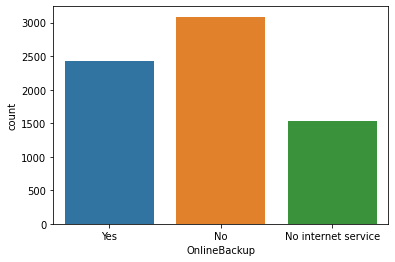

In [146]:
sns.countplot('OnlineBackup',data=dfnew)
plt.show()

#### Apart from customers without Internet service (approx. 1500), approx. 2400 customers take online backup and approx. 3100 don't. 

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


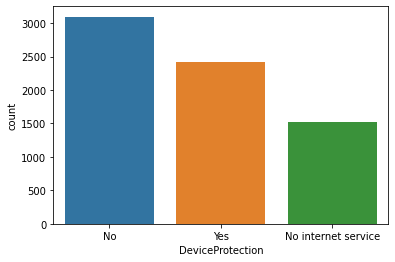

In [147]:
sns.countplot('DeviceProtection',data=dfnew)
plt.show()

#### We have approx. 3100 customers without DeviceProtection and approx. 2300 customers who signed up for DeviceProtection. 

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


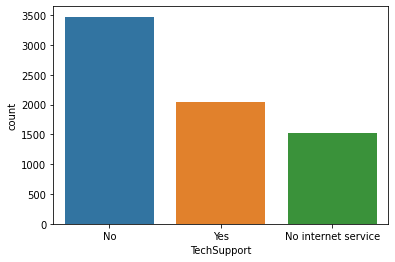

In [148]:
sns.countplot('TechSupport',data=dfnew)
plt.show()

#### Around 3400 customer do not have TechSupport and 2000 customers have it.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


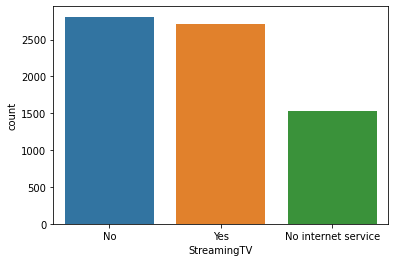

In [149]:
sns.countplot('StreamingTV',data=dfnew)
plt.show()

#### We have approx. equal number of customers who steam or do not steam TV. 

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


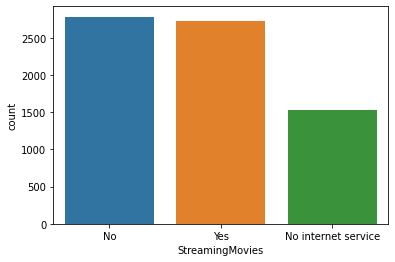

In [150]:
sns.countplot('StreamingMovies',data=dfnew)
plt.show()

#### As streaming TV, streaming Movie shows same numbers who streams or who do not.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


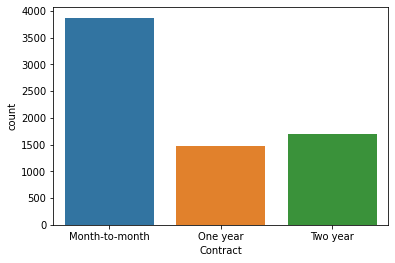

In [151]:
sns.countplot('Contract',data=dfnew)
plt.show()

#### From all the cutomers who are contracted, 3800 of them have monthly contract, 1600 of them have 2 years contract and around 1400 have 1 year contract.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


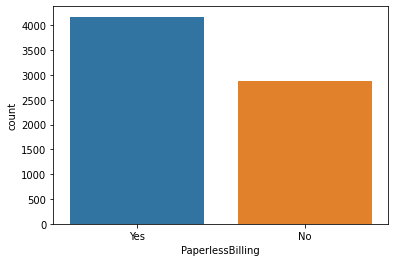

In [152]:
sns.countplot('PaperlessBilling',data=dfnew)
plt.show()

#### Over 4000 customers of all, have opted for Paperless billings and 2750 did not.

c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


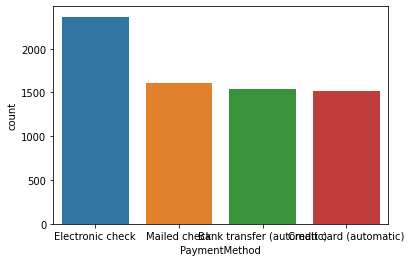

In [154]:
sns.countplot('PaymentMethod',data=dfnew)
plt.show()

#### Method of payment used by customers,  over 2300 customers use electronic check and around 1500 cutomers each, use Mailed check, Bank transfer and credit card for payment.

# Bivariant anaysis

Text(0.5, 1.0, 'Churn by Gender')

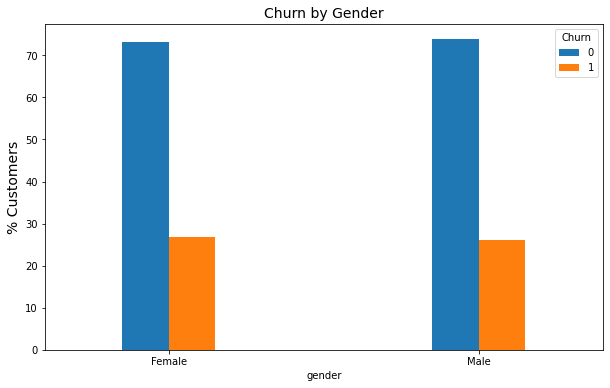

In [164]:
contract_churn = dfnew.groupby(['gender','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                rot = 0, 
                                                                figsize = (10,6))

ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Gender',size = 14)

#### In Female customers, more than 70% do not use telecome product and in male customers too more than 70% do not use telecome product.

Text(0.5, 1.0, 'Churn by SeniorCitizen')

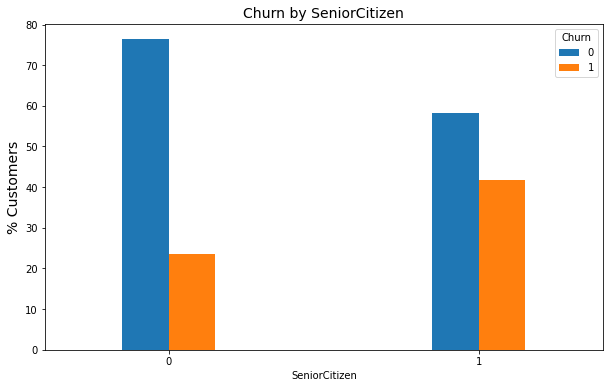

In [166]:
contract_churn = dfnew.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                rot = 0, 
                                                                figsize = (10,6))

ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by SeniorCitizen',size = 14)

#### 60% of Senior citizens do not use Telecome product and 40% of them use. In Young customers, 76% do not use the product and 24% do.

Text(0.5, 1.0, 'Churn by Partner')

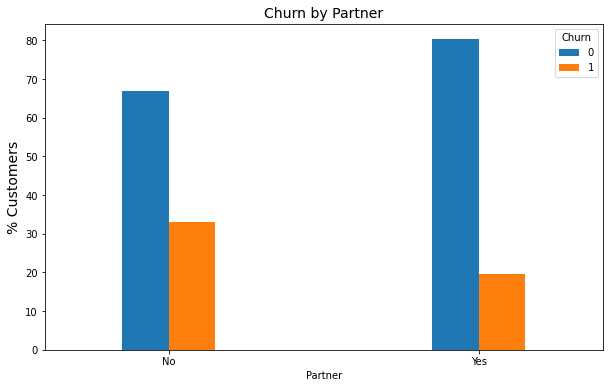

In [167]:
contract_churn = dfnew.groupby(['Partner','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                rot = 0, 
                                                                figsize = (10,6))

ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Partner',size = 14)

#### Out of all customerswho are Partners 80% do not use product and 20% do. In non-partners, 67% do not use product and 33% do use it.

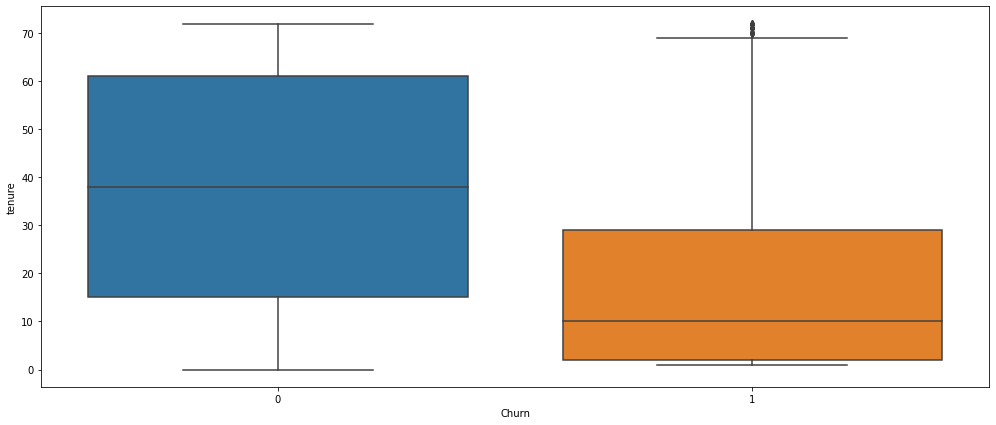

In [169]:
plt.figure(figsize=(17,7))
sns.boxplot(x='Churn', y='tenure', data= dfnew)
plt.show()

#### For customers who do not use telecome product now, have normally distributed tenure. But for customers who use product now, tenure is right sckewed with upto 5 outliers.

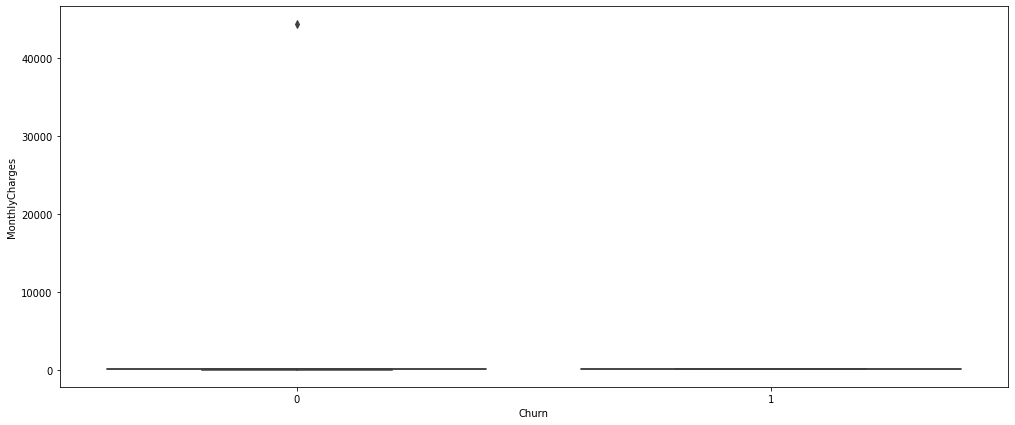

In [170]:
plt.figure(figsize=(17,7))
sns.boxplot(x='Churn', y='MonthlyCharges', data= dfnew)
plt.show()

#### Monthly charges have normally distributed data over churn or non churn customers, with one outright outlier. 

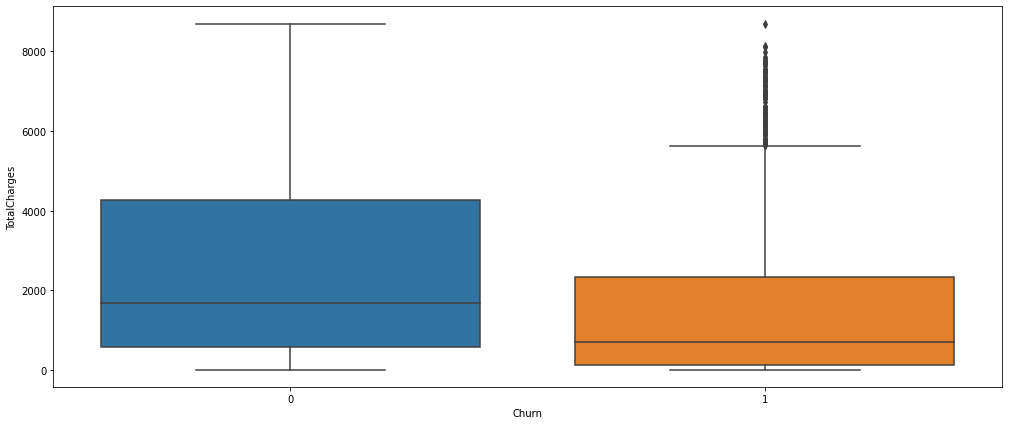

In [171]:
plt.figure(figsize=(17,7))
sns.boxplot(x='Churn', y='TotalCharges', data= dfnew)
plt.show()

#### For customers who do not use telecome product now, have normally distributed(slightly right sckewed) tenure. But for customers who use product now, tenure is right sckewed with multiple outliers.

# Multivariate Analysis

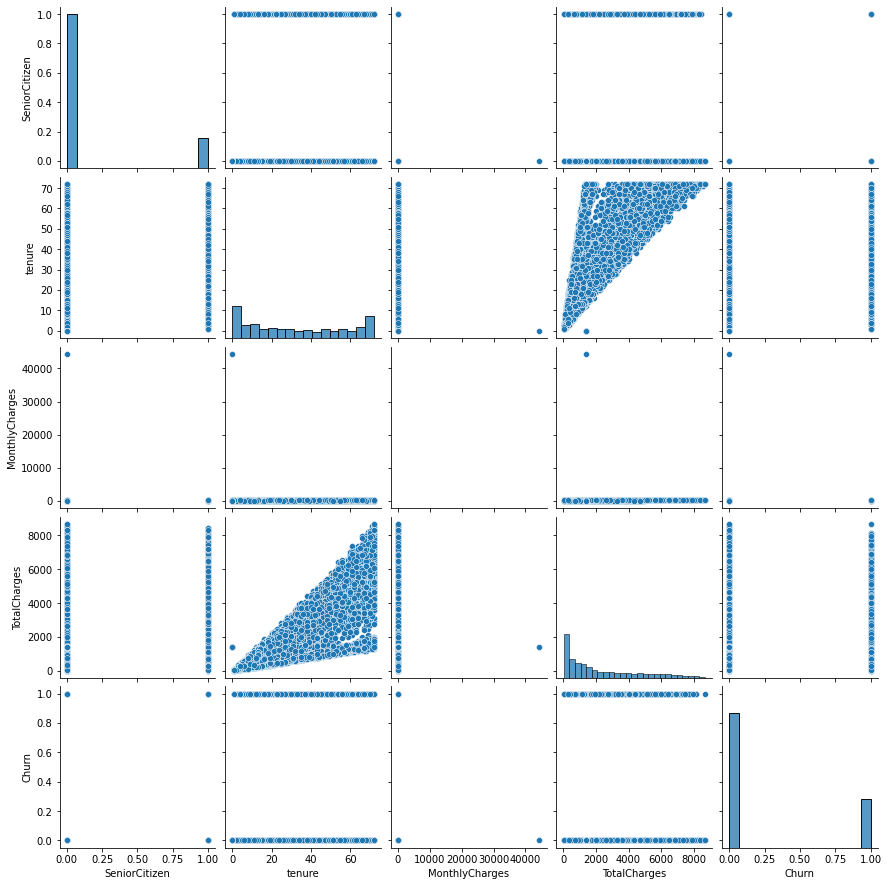

In [172]:
sns.pairplot(dfnew)
plt.show()

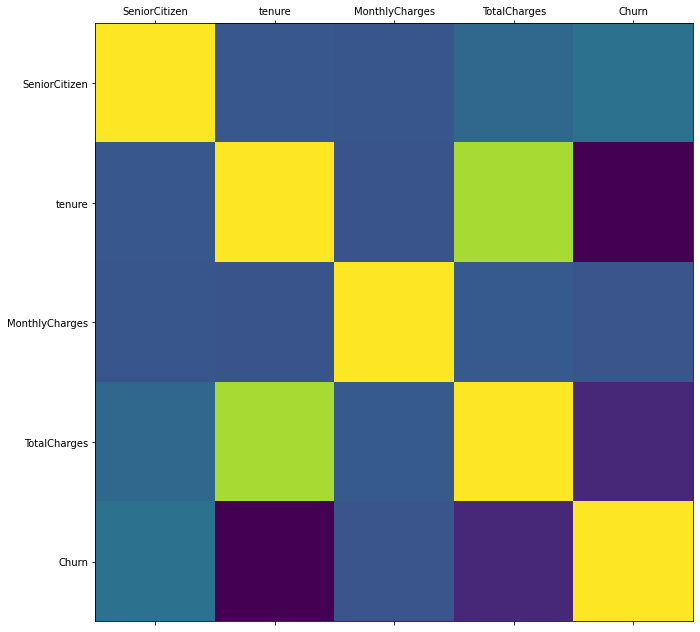

In [173]:
def plot_corr(dfnew, size=11):
    corr = dfnew.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(dfnew)

#### According to correlation and pair plot, there is no correlation between the attributes and churn. 

# Data pre-processing

In [181]:
columns=['tenure','MonthlyCharges','TotalCharges']

In [193]:
from decimal import Decimal
outliers = []
for c in columns:
    Q3 = np.percentile(df_dummies[c],75.0)
    Q1 = np.percentile(df_dummies[c],25.0)
    IQR = Q3 - Q1
    Threshold = IQR*1.5
    uf = Q3 + Threshold
    lf = Q1 - Threshold
    dfwoO = df_dummies.loc[(df_dummies[c] >= lf) & (df_dummies[c] <= uf)]
    mean= dfwoO[c].mean()
    df_dummies[c]=np.where(df_dummies[c]>uf,mean,df_dummies[c])
    df_dummies[c]=np.where(df_dummies[c]<lf,mean,df_dummies[c])
    #checking if there are any outliers remaining
    for i in df_dummies[c]:
        if i < lf or i > uf:
           outliers.append(i)
        
print(outliers)

[]


c:\python\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


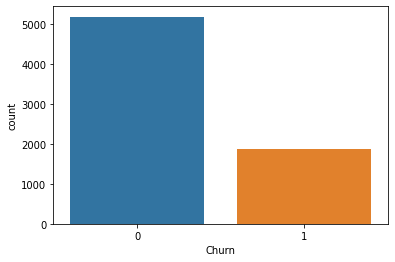

In [192]:
#Target variable distribution
sns.countplot('Churn',data=dfnew)
plt.show()

### Target variable does not seem to be balanced. We will balance the training data after split. 

In [418]:
df_dummies=df_dummies.drop(['gender_Male','Partner_No','Dependents_No','PhoneService_No','MultipleLines_No','InternetService_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No','PaperlessBilling_No','Contract_Month-to-month','PaymentMethod_Mailed check'], axis=1)

In [225]:
#training data
df_new1 = df_dummies.iloc[:4900, :]
df_new1[df_new1.Churn == 0].count()

SeniorCitizen                              3616
tenure                                     3616
MonthlyCharges                             3616
TotalCharges                               3616
Churn                                      3616
gender_Female                              3616
Partner_Yes                                3616
Dependents_Yes                             3616
PhoneService_Yes                           3616
MultipleLines_No phone service             3616
MultipleLines_Yes                          3616
InternetService_DSL                        3616
InternetService_Fiber optic                3616
OnlineSecurity_No internet service         3616
OnlineSecurity_Yes                         3616
OnlineBackup_No internet service           3616
OnlineBackup_Yes                           3616
DeviceProtection_No internet service       3616
DeviceProtection_Yes                       3616
TechSupport_No internet service            3616
TechSupport_Yes                         

In [226]:
#testing data
df_new2 = df_dummies.iloc[4901:, :]

In [227]:
from sklearn.utils import resample
df_majority = df_new1[df_new1.Churn == 0]
df_minority = df_new1[df_new1.Churn == 1]

df_min = resample(df_minority, replace = True, n_samples=3616,random_state=123)

df_balanced = pd.concat([df_majority, df_min])

df_balanced.Churn.value_counts()

1    3616
0    3616
Name: Churn, dtype: int64

In [231]:
x_train = df_balanced.drop('Churn', axis = 1)
y_train = df_balanced['Churn']

In [232]:
x_test = df_new2.drop('Churn', axis = 1)
y_test = df_new2['Churn']

In [233]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7232 entries, 0 to 3834
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7232 non-null   int64  
 1   tenure                                   7232 non-null   float64
 2   MonthlyCharges                           7232 non-null   float32
 3   TotalCharges                             7232 non-null   float64
 4   gender_Female                            7232 non-null   uint8  
 5   Partner_Yes                              7232 non-null   uint8  
 6   Dependents_Yes                           7232 non-null   uint8  
 7   PhoneService_Yes                         7232 non-null   uint8  
 8   MultipleLines_No phone service           7232 non-null   uint8  
 9   MultipleLines_Yes                        7232 non-null   uint8  
 10  InternetService_DSL                      7232 no

In [276]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 4901 to 7042
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            2142 non-null   int64  
 1   tenure                                   2142 non-null   float64
 2   MonthlyCharges                           2142 non-null   float32
 3   TotalCharges                             2142 non-null   float64
 4   gender_Female                            2142 non-null   uint8  
 5   Partner_Yes                              2142 non-null   uint8  
 6   Dependents_Yes                           2142 non-null   uint8  
 7   PhoneService_Yes                         2142 non-null   uint8  
 8   MultipleLines_No phone service           2142 non-null   uint8  
 9   MultipleLines_Yes                        2142 non-null   uint8  
 10  InternetService_DSL                      2142

### Both training and testing data have same characteristics 

# Modeling

## 1. Decision Tree Classifier 

In [241]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

In [242]:
print(dTree.score(x_train, y_train))
print(dTree.score(x_test, y_test))

0.9988938053097345
0.7259570494864612


In [243]:
from sklearn.tree import export_graphviz

train_char_label = ['No', 'Yes']
Credit_Tree_File = open('credit_tree.dot','w')
dot_data = export_graphviz(dTree, out_file=Credit_Tree_File, feature_names = list(x_train), class_names = list(train_char_label))
Credit_Tree_File.close()

In [ ]:
from os import system
from IPython.display import Image

#Works only if "dot" command works on you machine

retCode = system("dot -Tpng credit_tree.dot -o credit_tree.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_tree.png"))

In [244]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state=1)
dTreeR.fit(x_train, y_train)
print(dTreeR.score(x_train, y_train))
print(dTreeR.score(x_test, y_test))

0.760370575221239
0.7521008403361344


In [247]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = x_train.columns))

                                              Imp
SeniorCitizen                            0.001415
tenure                                   0.107684
MonthlyCharges                           0.019126
TotalCharges                             0.015959
gender_Female                            0.000000
Partner_Yes                              0.000000
Dependents_Yes                           0.000000
PhoneService_Yes                         0.000000
MultipleLines_No phone service           0.000000
MultipleLines_Yes                        0.000000
InternetService_DSL                      0.000000
InternetService_Fiber optic              0.114394
OnlineSecurity_No internet service       0.000000
OnlineSecurity_Yes                       0.000000
OnlineBackup_No internet service         0.000000
OnlineBackup_Yes                         0.000000
DeviceProtection_No internet service     0.000000
DeviceProtection_Yes                     0.000000
TechSupport_No internet service          0.000000


#### For DecisionTreeClassifier, tenure, InternetService_Fiber optic,Contract_One year, Contract_Two year are the most important predictor variables to predict churn.

0.7525676937441643


<AxesSubplot:>

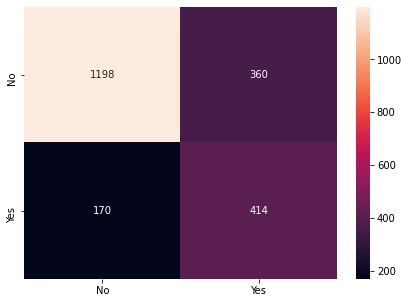

In [248]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(dTreeR.score(x_test , y_test))
y_predict = dTreeR.predict(x_test)

cm = confusion_matrix(y_test, y_predict, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

## 2. Bagging Classifier 

In [250]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(base_estimator=dTree, n_estimators=50,random_state=1)
#bgcl = BaggingClassifier(n_estimators=50,random_state=1)

bgcl = bgcl.fit(x_train, y_train)

0.7712418300653595


<AxesSubplot:>

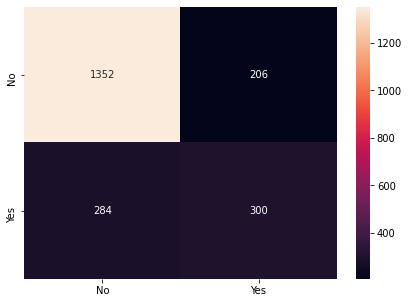

In [251]:
from sklearn.metrics import confusion_matrix

y_predict = bgcl.predict(x_test)

print(bgcl.score(x_test , y_test))

cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

## 3. Random Forest Classifier 

In [260]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
rfcl = rfcl.fit(x_train, y_train)

0.7665732959850607


<AxesSubplot:>

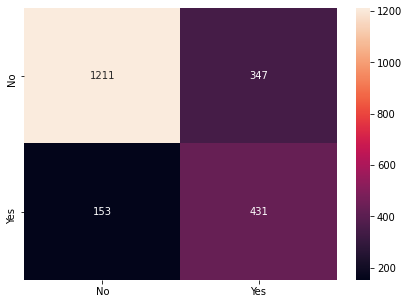

In [261]:
y_predict = rfcl.predict(x_test)
print(rfcl.score(x_test, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [266]:
print (pd.DataFrame(rfcl.feature_importances_, columns = ["Imp"], index = x_train.columns))

                                              Imp
SeniorCitizen                            0.004527
tenure                                   0.183609
MonthlyCharges                           0.049935
TotalCharges                             0.115360
gender_Female                            0.002236
Partner_Yes                              0.004887
Dependents_Yes                           0.004173
PhoneService_Yes                         0.001727
MultipleLines_No phone service           0.001857
MultipleLines_Yes                        0.003637
InternetService_DSL                      0.031677
InternetService_Fiber optic              0.089847
OnlineSecurity_No internet service       0.026958
OnlineSecurity_Yes                       0.034118
OnlineBackup_No internet service         0.027019
OnlineBackup_Yes                         0.006104
DeviceProtection_No internet service     0.028260
DeviceProtection_Yes                     0.005226
TechSupport_No internet service          0.028411


#### From random forest algorithm, 2 year contract, tenure and total charges are the most important predictor variables to predict churn. The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA.

## 4. AdaBoost Classifier 

In [254]:
from sklearn.ensemble import AdaBoostClassifier
#abcl = AdaBoostClassifier(n_estimators=10, random_state=1)
abcl = AdaBoostClassifier( n_estimators=50,random_state=1)
abcl = abcl.fit(x_train, y_train)

0.7595704948646125


<AxesSubplot:>

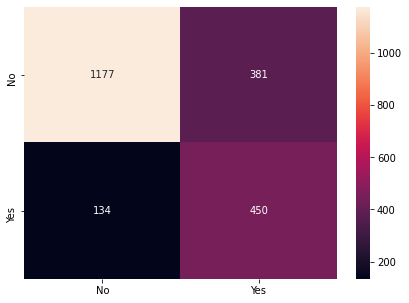

In [255]:
y_predict = abcl.predict(x_test)
print(abcl.score(x_test , y_test))

cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [268]:
print (pd.DataFrame(abcl.feature_importances_, columns = ["Imp"], index = x_train.columns))

                                          Imp
SeniorCitizen                            0.02
tenure                                   0.16
MonthlyCharges                           0.08
TotalCharges                             0.36
gender_Female                            0.00
Partner_Yes                              0.00
Dependents_Yes                           0.00
PhoneService_Yes                         0.00
MultipleLines_No phone service           0.00
MultipleLines_Yes                        0.02
InternetService_DSL                      0.02
InternetService_Fiber optic              0.02
OnlineSecurity_No internet service       0.00
OnlineSecurity_Yes                       0.02
OnlineBackup_No internet service         0.02
OnlineBackup_Yes                         0.00
DeviceProtection_No internet service     0.00
DeviceProtection_Yes                     0.00
TechSupport_No internet service          0.02
TechSupport_Yes                          0.02
StreamingTV_No internet service   

#### From AdaBoostClassifier, 2 year contract, tenure, monthly charges and total charges are the most important predictor variables to predict churn. The results from random forest are very similar to that of and in line to what we had expected from our EDA. 

## 5. Gradient Boost Classifier 

In [256]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50,random_state=1)
gbcl = gbcl.fit(x_train, y_train)

0.7675070028011205


<AxesSubplot:>

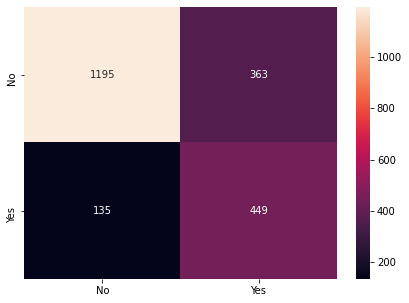

In [257]:
y_predict = gbcl.predict(x_test)
print(gbcl.score(x_test, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [269]:
print (pd.DataFrame(gbcl.feature_importances_, columns = ["Imp"], index = x_train.columns))

                                              Imp
SeniorCitizen                            0.010019
tenure                                   0.260123
MonthlyCharges                           0.024774
TotalCharges                             0.047293
gender_Female                            0.000765
Partner_Yes                              0.001113
Dependents_Yes                           0.000300
PhoneService_Yes                         0.000861
MultipleLines_No phone service           0.003132
MultipleLines_Yes                        0.002139
InternetService_DSL                      0.005755
InternetService_Fiber optic              0.130508
OnlineSecurity_No internet service       0.000875
OnlineSecurity_Yes                       0.017763
OnlineBackup_No internet service         0.026896
OnlineBackup_Yes                         0.001169
DeviceProtection_No internet service     0.015132
DeviceProtection_Yes                     0.000221
TechSupport_No internet service          0.027767


#### From GradientBoostingClassifier, 2 year contract, 1 year contract, tenure, InternetService_Fiber optic  are the most important predictor variables to predict churn. The results from random forest, AdaBoostClassifier are very similar and in line to what we had expected from our EDA. 

## 6. XGradient Boost Classifier 

In [264]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(x_train, y_train)

c:\python\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:47:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

0.7787114845938375


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


<AxesSubplot:>

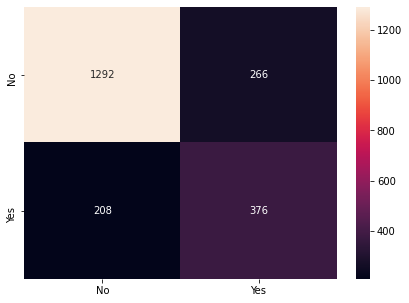

In [265]:
y_predict = model.predict(x_test)
print(model.score(x_test, y_test))
cm=confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [275]:
print (pd.DataFrame(model.feature_importances_, columns = ["Imp"], index = x_train.columns))

                                              Imp
SeniorCitizen                            0.010366
tenure                                   0.016437
MonthlyCharges                           0.011382
TotalCharges                             0.011315
gender_Female                            0.009318
Partner_Yes                              0.006558
Dependents_Yes                           0.007738
PhoneService_Yes                         0.017298
MultipleLines_No phone service           0.000000
MultipleLines_Yes                        0.013363
InternetService_DSL                      0.037248
InternetService_Fiber optic              0.168281
OnlineSecurity_No internet service       0.015728
OnlineSecurity_Yes                       0.014623
OnlineBackup_No internet service         0.000000
OnlineBackup_Yes                         0.010220
DeviceProtection_No internet service     0.000000
DeviceProtection_Yes                     0.011040
TechSupport_No internet service          0.000000


# GUI using tkinter

In [397]:
from tkinter import *
window= Tk()
window.title('GUI')
#window.geometry("400x400")

def show():
    #customerID = ''.join(random.sample(string.ascii_letters, 8))
    SeniorCitizen = clicked_sc.get()
    tenure = text_t.get()
    if not tenure:
        tenure = 0
    MonthlyCharges = text_mc.get()
    if not MonthlyCharges:
        MonthlyCharges = 0
    TotalCharges = text_tc.get()
    if not TotalCharges:
        TotalCharges = 0
    if clicked_gen.get() == 'Female':
        gender = 1
    else:
        gender = 0
    if clicked_p.get() == 'Yes':
        partner = 1
    else:
        partner = 0
    if clicked_d.get() == 'Yes':
        dependents = 1
    else:
        dependents = 0
    if clicked_ps.get() == 'Yes':
        ps = 1
    else:
        ps = 0
    mlnps = clicked_ml.get()
    if mlnps == 'No phone service':
        mlnps = 1
        mly = 0
    elif mlnps == 'Yes':
        mlnps = 0
        mly = 1
    else:
        mlnps = 0
        mly = 0
    isdsl=clicked_is.get()
    if isdsl == 'DSL':
        isdsl = 1
        isfo = 0
    elif mlnps == 'Yes':
        isdsl = 0
        isfo = 1
    else:
        isdsl = 0
        isfo = 0
    osnis =clicked_os.get()
    if osnis == 'No internet service':
        osnis = 1
        osy = 0
    elif osnis == 'Yes':
        osnis = 0
        osy = 1
    else:
        osnis = 0
        osy = 0
    obnis = clicked_ob.get()
    if obnis == 'No internet service':
        obnis = 1
        oby = 0
    elif obnis == 'Yes':
        obnis = 0
        oby = 1
    else:
        obnis = 0
        oby = 0
    dpnis = clicked_dp.get()
    if dpnis == 'No internet service':
        dpnis = 1
        dpy = 0
    elif dpnis == 'Yes':
        dpnis = 0
        dpy = 1
    else:
        dpnis = 0
        dpy = 0
    tsnis = clicked_ts.get()
    if tsnis == 'No internet service':
        tsnis = 1
        tsy = 0
    elif tsnis == 'Yes':
        tsnis = 0
        tsy = 1
    else:
        tsnis = 0
        tsy = 0
    stnis = clicked_st.get()
    if stnis == 'No internet service':
        stnis = 1
        sty = 0
    elif stnis == 'Yes':
        stnis = 0
        sty = 1
    else:
        stnis = 0
        sty = 0
    smnis = clicked_sm.get()
    if smnis == 'No internet service':
        smnis = 1
        smy = 0
    elif smnis == 'Yes':
        smnis = 0
        smy = 1
    else:
        smnis = 0
        smy = 0
    coy = clicked_c.get()
    if coy == 'One year':
        coy = 1
        cty = 0
    elif coy == 'Two year':
        coy = 0
        cty = 1
    else:
        coy = 0
        cty = 0
    if clicked_pb.get() == 'Yes':
        plb = 1
    else:
        plb = 0
    pmbt = clicked_pm.get()
    if pmbt == 'Bank transfer (automatic)':
        pmbt = 1
        pmcc = 0
        pmec = 0
    elif pmbt == 'Credit card (automatic)':
        pmbt = 0
        pmcc = 1
        pmec = 0
    elif pmbt == 'Electronic check':
        pmbt = 0
        pmcc = 0
        pmec = 1
    else:
        pmbt = 0
        pmcc = 0
        pmec = 0  
    x_test.append([SeniorCitizen, tenure, MonthlyCharges, TotalCharges, gender, partner, ps,mlnps,mly,isdsl,isfo,osnis,osy,obnis,oby,dpnis,dpy,tsnis,tsy,stnis,sty,smnis,smy,coy,cty,plb,pmbt,pmcc,pmec])
    y_predict = model.predict(x_test)
    if y_predict[len(y_predict)-1] == 0:
        prediction = 'No'
    else:
        prediction = 'Yes'
    Label(window, text='Prediction:', bg='white',fg='black',font='none 12 bold').grid(row=20, column=0, sticky=W)
    Label(window, text=prediction, bg='white',fg='black',font='none 12 bold').grid(row=20, column=1, sticky=W)
    
    
    
Label(window, text='Gender:', bg='white',fg='black',font='none 12 bold').grid(row=0, column=0, sticky=W)
optionGen = dfnew.gender.unique()
clicked_gen = StringVar()
clicked_gen.set(optionGen[0])
gen_drop = OptionMenu(window, clicked_gen,*optionGen).grid(row=0, column=1, sticky=W)

Label(window, text='Senior Citizen:', bg='white',fg='black',font='none 12 bold').grid(row=1, column=0, sticky=W)
optionSC = dfnew.SeniorCitizen.unique()
clicked_sc = StringVar()
clicked_sc.set(optionSC[0])
gen_sc = OptionMenu(window, clicked_sc,*optionSC).grid(row=1, column=1, sticky=W)

Label(window, text='Partner:', bg='white',fg='black',font='none 12 bold').grid(row=2, column=0, sticky=W)
optionP = dfnew.Partner.unique()
clicked_p = StringVar()
clicked_p.set(optionP[0])
gen_p = OptionMenu(window, clicked_p,*optionP).grid(row=2, column=1, sticky=W)

Label(window, text='Dependents:', bg='white',fg='black',font='none 12 bold').grid(row=3, column=0, sticky=W)
optionD = dfnew.Dependents.unique()
clicked_d = StringVar()
clicked_d.set(optionD[0])
gen_d = OptionMenu(window, clicked_d,*optionD).grid(row=3, column=1, sticky=W)

Label(window, text='Tenure:', bg='white',fg='black',font='none 12 bold').grid(row=4, column=0, sticky=W)
text_t = Entry(window, width =20,bg='white')
text_t.grid(row=4, column=1, sticky=W)

Label(window, text='PhoneService:', bg='white',fg='black',font='none 12 bold').grid(row=5, column=0, sticky=W)
optionPS = dfnew.PhoneService.unique()
clicked_ps = StringVar()
clicked_ps.set(optionPS[0])
gen_ps = OptionMenu(window, clicked_ps,*optionPS).grid(row=5, column=1, sticky=W)

Label(window, text='MultipleLines:', bg='white',fg='black',font='none 12 bold').grid(row=6, column=0, sticky=W)
optionML = dfnew.MultipleLines.unique()
clicked_ml = StringVar()
clicked_ml.set(optionML[0])
gen_ml = OptionMenu(window, clicked_ml,*optionML).grid(row=6, column=1, sticky=W)


Label(window, text='InternetService:', bg='white',fg='black',font='none 12 bold').grid(row=7, column=0, sticky=W)
optionIS = dfnew.InternetService.unique()
clicked_is = StringVar()
clicked_is.set(optionIS[0])
gen_is = OptionMenu(window, clicked_is,*optionIS).grid(row=7, column=1, sticky=W)

Label(window, text='OnlineSecurity:', bg='white',fg='black',font='none 12 bold').grid(row=8, column=0, sticky=W)
optionOS = dfnew.OnlineSecurity.unique()
clicked_os = StringVar()
clicked_os.set(optionOS[0])
gen_os = OptionMenu(window, clicked_os,*optionOS).grid(row=8, column=1, sticky=W)

Label(window, text='OnlineBackup:', bg='white',fg='black',font='none 12 bold').grid(row=9, column=0, sticky=W)
optionOB = dfnew.OnlineBackup.unique()
clicked_ob = StringVar()
clicked_ob.set(optionOB[0])
gen_ob = OptionMenu(window, clicked_ob,*optionOB).grid(row=9, column=1, sticky=W)

Label(window, text='DeviceProtection:', bg='white',fg='black',font='none 12 bold').grid(row=10, column=0, sticky=W)
optionDP = dfnew.DeviceProtection.unique()
clicked_dp = StringVar()
clicked_dp.set(optionDP[0])
gen_dp = OptionMenu(window, clicked_dp,*optionDP).grid(row=10, column=1, sticky=W)

Label(window, text='TechSupport:', bg='white',fg='black',font='none 12 bold').grid(row=11, column=0, sticky=W)
optionTS = dfnew.TechSupport.unique()
clicked_ts = StringVar()
clicked_ts.set(optionTS[0])
gen_ts = OptionMenu(window, clicked_ts,*optionTS).grid(row=11, column=1, sticky=W)


Label(window, text='StreamingTV:', bg='white',fg='black',font='none 12 bold').grid(row=12, column=0, sticky=W)
optionST = dfnew.StreamingTV.unique()
clicked_st = StringVar()
clicked_st.set(optionST[0])
gen_st = OptionMenu(window, clicked_st,*optionST).grid(row=12, column=1, sticky=W)


Label(window, text='StreamingMovies:', bg='white',fg='black',font='none 12 bold').grid(row=13, column=0, sticky=W)
optionSM = dfnew.StreamingMovies.unique()
clicked_sm = StringVar()
clicked_sm.set(optionSM[0])
gen_sm = OptionMenu(window, clicked_sm,*optionSM).grid(row=13, column=1, sticky=W)

Label(window, text='Contract:', bg='white',fg='black',font='none 12 bold').grid(row=14, column=0, sticky=W)
optionC = dfnew.Contract.unique()
clicked_c = StringVar()
clicked_c.set(optionC[0])
gen_c = OptionMenu(window, clicked_c,*optionC).grid(row=14, column=1, sticky=W)

Label(window, text='PaperlessBilling:', bg='white',fg='black',font='none 12 bold').grid(row=15, column=0, sticky=W)
optionPB = dfnew.PaperlessBilling.unique()
clicked_pb = StringVar()
clicked_pb.set(optionPB[0])
gen_pb = OptionMenu(window, clicked_pb,*optionPB).grid(row=15, column=1, sticky=W)

Label(window, text='PaymentMethod:', bg='white',fg='black',font='none 12 bold').grid(row=16, column=0, sticky=W)
optionPM = dfnew.PaymentMethod.unique()
clicked_pm = StringVar()
clicked_pm.set(optionPM[0])
gen_pm = OptionMenu(window, clicked_pm,*optionPM).grid(row=16, column=1, sticky=W)

Label(window, text='MonthlyCharges:', bg='white',fg='black',font='none 12 bold').grid(row=17, column=0, sticky=W)
text_mc = Entry(window, width =20,bg='white')
text_mc.grid(row=17, column=1, sticky=W)


Label(window, text='TotalCharges:', bg='white',fg='black',font='none 12 bold').grid(row=18, column=0, sticky=W)
text_tc = Entry(window, width =20,bg='white')
text_tc.grid(row=18, column=1, sticky=W)


myButton = Button(window, text='Submit and Predict', command=show).grid(row=19, column=1, sticky=W)

window.mainloop()


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


#### From XGBoost, 2 year contract, 1 year contract, InternetService_Fiber optic are the most important predictor variables to predict churn. The results from random forest, AdaBoostClassifier, GradientBoost are very similar and in line to what we had expected from our EDA. 

# Conclusion

#### Comparison of all algorithms 

In [279]:
print('Decision tree classifier accuracy '+str(dTree.score(x_test, y_test)))
print('Bagging tree classifier accuracy '+str(bgcl.score(x_test , y_test)))
print('Random Forest classifier accuracy '+str(rfcl.score(x_test, y_test)))
print('AdaBoost classifier accuracy '+str(abcl.score(x_test , y_test)))
print('Gradient Boost classifier accuracy '+str(gbcl.score(x_test, y_test)))
print('XGradient Boost classifier accuracy '+str(model.score(x_test, y_test)))

Decision tree classifier accuracy 0.7259570494864612
Bagging tree classifier accuracy 0.7712418300653595
Random Forest classifier accuracy 0.7665732959850607
AdaBoost classifier accuracy 0.7595704948646125
Gradient Boost classifier accuracy 0.7675070028011205
XGradient Boost classifier accuracy 0.7787114845938375


c:\python\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


#### Looking at the accuracy of all the Ensemble models, they do not differ alot. But XGBoost gives the best accuracy of 88% followed by Bagging , Gradient Boost, Random forest with 77% accuracy. Decision tree gave least accuracy with 72%.

In [396]:
print (pd.DataFrame(model.feature_importances_, columns = ["Imp"], index = x_train.columns))

                                              Imp
SeniorCitizen                            0.010366
tenure                                   0.016437
MonthlyCharges                           0.011382
TotalCharges                             0.011315
gender_Female                            0.009318
Partner_Yes                              0.006558
Dependents_Yes                           0.007738
PhoneService_Yes                         0.017298
MultipleLines_No phone service           0.000000
MultipleLines_Yes                        0.013363
InternetService_DSL                      0.037248
InternetService_Fiber optic              0.168281
OnlineSecurity_No internet service       0.015728
OnlineSecurity_Yes                       0.014623
OnlineBackup_No internet service         0.000000
OnlineBackup_Yes                         0.010220
DeviceProtection_No internet service     0.000000
DeviceProtection_Yes                     0.011040
TechSupport_No internet service          0.000000


#### After selecting XGBoost model, features like InternetService_Fiber optic, InternetService_DSL, Contract_One year, Contract_Two year makes difference in the prediction of Churn.

#### OnlineSecurity, OnlineBackup, DeviceProtection,TechSupport,StreamingTV, StreamingMovies these features depends on whether InternetService is taken or not. Therefore, in these features, there is redundant value for 'No internet service' which is not required.